# **Sentiment Analysis on IMDB Using BoW and TF-IDF (TensorFlow-Keras)**

# 1. Load IMDB Dataset and Preprocess the Text
In this step, the IMDB dataset is loaded from Keras. The dataset contains thousands of movie reviews already labeled as positive or negative. Since the IMDB dataset stores reviews as sequences of integers (representing words), each numeric sequence is converted back to readable text using the dataset’s word index. This allows us to apply text-based feature extraction methods later.

The Bag-of-Words approach transforms each review into a vector based on word counts. A dictionary containing the most frequent words is first extracted, and then, each review is encoded based on how many times each word appears. This representation ignores grammar and word order but captures the frequency of words that may influence sentiment (such as “great,” “boring,” or “bad”).

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import numpy as np
VOCAB_SIZE = 10000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

word_index = imdb.get_word_index()
reverse_word_index = {v:k for k,v in word_index.items()}

def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i-3, "?") for i in encoded_review])

texts_train = [decode_review(x) for x in X_train]
texts_test = [decode_review(x) for x in X_test]


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 2. BAG-OF-WORDS FEATURE EXTRACTION
The Bag-of-Words approach transforms each review into a vector based on word counts. A dictionary containing the most frequent words is first extracted, and then, each review is encoded based on how many times each word appears. This representation ignores grammar and word order but captures the frequency of words that may influence sentiment (such as “great,” “boring,” or “bad”).

In [4]:
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(texts_train)
X_test_bow = bow_vectorizer.transform(texts_test)


# Model using BoW features

The Bag-of-Words matrix is given as input to a fully-connected neural network classifier. The model learns patterns from the word count vectors and predicts whether a review is positive (label 1) or negative (label 0). The model is trained using binary cross-entropy since it is a binary classification task. After training, we validate performance using test data.



In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_bow = Sequential([
    Dense(32, activation='relu', input_shape=(5000,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_bow.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_bow = model_bow.fit(
    X_train_bow.toarray(), y_train,
    validation_data=(X_test_bow.toarray(), y_test),
    epochs=3, batch_size=512, verbose=2
)


Epoch 1/3
49/49 - 5s - 107ms/step - accuracy: 0.7958 - loss: 0.4728 - val_accuracy: 0.8724 - val_loss: 0.3302
Epoch 2/3
49/49 - 3s - 52ms/step - accuracy: 0.9007 - loss: 0.2652 - val_accuracy: 0.8825 - val_loss: 0.3007
Epoch 3/3
49/49 - 3s - 60ms/step - accuracy: 0.9216 - loss: 0.2160 - val_accuracy: 0.8810 - val_loss: 0.3048


# TF-IDF FEATURE EXTRACTION
TF-IDF (Term Frequency–Inverse Document Frequency) transforms text into weighted feature vectors. Words that appear often in one review but rarely across other reviews receive higher values. This highlights important words and reduces the effect of common words such as “the” or “movie.” TF-IDF usually provides better representation compared to basic word counts.



In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)
X_test_tfidf = tfidf_vectorizer.transform(texts_test)


# Model using TF-IDF features
A second neural network is trained using the TF-IDF feature vectors as input. The architecture remains similar, allowing comparison with the BoW-based model. Since TF-IDF emphasizes meaningful terms, the model often learns sentiment-related patterns more effectively and tends to achieve higher accuracy.

In [9]:
model_tfidf = Sequential([
    Dense(32, activation='relu', input_shape=(5000,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_tfidf = model_tfidf.fit(
    X_train_tfidf.toarray(), y_train,
    validation_data=(X_test_tfidf.toarray(), y_test),
    epochs=3, batch_size=512, verbose=2
)


Epoch 1/3
49/49 - 6s - 127ms/step - accuracy: 0.7812 - loss: 0.6409 - val_accuracy: 0.8378 - val_loss: 0.5566
Epoch 2/3
49/49 - 3s - 64ms/step - accuracy: 0.8696 - loss: 0.4357 - val_accuracy: 0.8695 - val_loss: 0.3625
Epoch 3/3
49/49 - 3s - 64ms/step - accuracy: 0.8990 - loss: 0.2859 - val_accuracy: 0.8814 - val_loss: 0.2942


# Classification Report
A classification report provides detailed evaluation metrics including precision, recall, and F1-score. This gives deeper insight compared to accuracy alone, especially in cases where prediction distribution is imbalanced.

In [12]:
from sklearn.metrics import classification_report

y_pred_bow = (model_bow.predict(X_test_bow) > 0.5).astype("int32")
print("Classification Report — Bag-of-Words")
print(classification_report(y_test, y_pred_bow))

y_pred_tfidf = (model_tfidf.predict(X_test_tfidf) > 0.5).astype("int32")
print("Classification Report — TF-IDF")
print(classification_report(y_test, y_pred_tfidf))


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Classification Report — Bag-of-Words
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12500
           1       0.87      0.90      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report — TF-IDF
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



# 4. Evaluate Both Models
Finally, both trained models are evaluated using accuracy metrics on the same test dataset. Their performance is compared to observe which feature extraction method results in better sentiment prediction. Typically, the TF-IDF model performs slightly better than Bag-of-Words because of its weighted representation.

In [10]:
loss_bow, acc_bow = model_bow.evaluate(X_test_bow.toarray(), y_test)
loss_tfidf, acc_tfidf = model_tfidf.evaluate(X_test_tfidf.toarray(), y_test)

print("\n🔎 RESULTS")
print(f"Bag-of-Words Accuracy: {acc_bow:.4f}")
print(f"TF-IDF Accuracy:      {acc_tfidf:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8802 - loss: 0.3060
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8800 - loss: 0.2942

🔎 RESULTS
Bag-of-Words Accuracy: 0.8810
TF-IDF Accuracy:      0.8814


# Visualization of Training Performance
This step presents a visual summary of the model's learning progress during training. The plots display how the accuracy changes for both the training and validation sets across multiple epochs. If the validation accuracy increases steadily, it means the model is learning effectively. However, if the training accuracy continues to increase while validation accuracy remains low or decreases, it may indicate overfitting. By comparing graphs for the Bag-of-Words and TF-IDF models, we observe which feature representation provides better and more stable learning behavior.

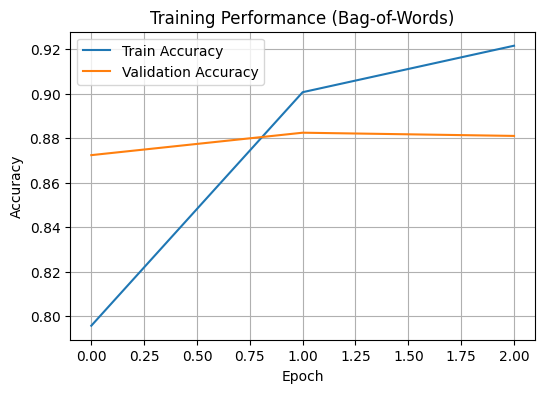

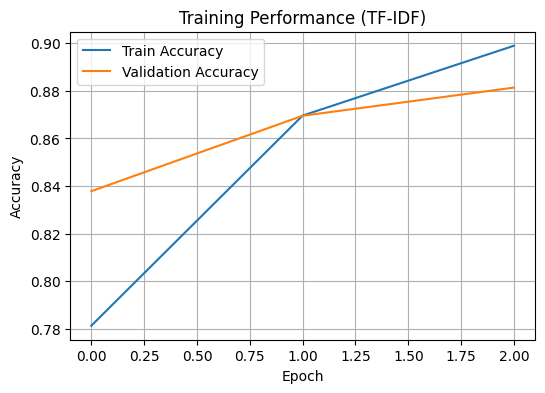

In [11]:
import matplotlib.pyplot as plt

# For Bag-of-Words model
plt.figure(figsize=(6,4))
plt.plot(history_bow.history['accuracy'], label='Train Accuracy')
plt.plot(history_bow.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training Performance (Bag-of-Words)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# For TF-IDF model
plt.figure(figsize=(6,4))
plt.plot(history_tfidf.history['accuracy'], label='Train Accuracy')
plt.plot(history_tfidf.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training Performance (TF-IDF)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix (Heatmap Visualization)
A confusion matrix shows how many positive and negative reviews were classified correctly or incorrectly. Darker diagonal cells indicate strong performance. Comparing matrices for TF-IDF and BoW reveals which method classifies better.

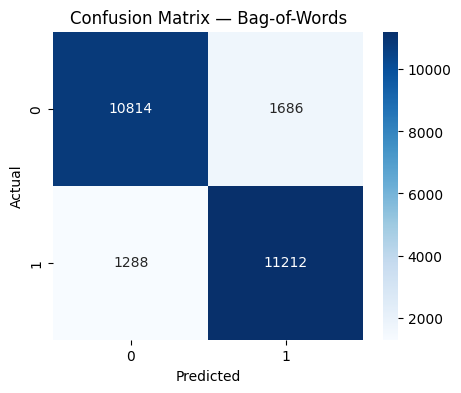

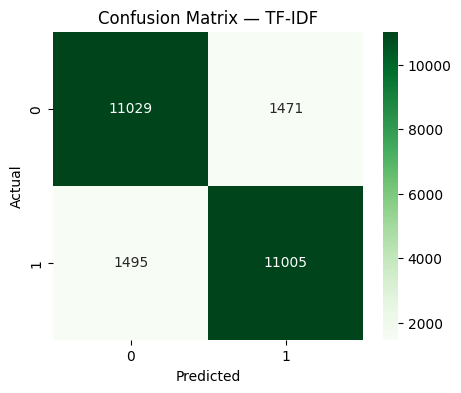

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_bow = confusion_matrix(y_test, y_pred_bow)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bow, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Bag-of-Words")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — TF-IDF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Sample Predictions (Human-Readable Output)**bold text**
Here, we manually test real sentences to evaluate how both models interpret sentiment. This allows us to observe the model’s real-world behavior outside of the test dataset.

In [14]:
sample_text = [
    "The movie was absolutely wonderful and inspiring",
    "This was the worst film I have ever seen"
]

sample_bow = bow_vectorizer.transform(sample_text)
sample_tfidf = tfidf_vectorizer.transform(sample_text)

print("BoW Predictions:", model_bow.predict(sample_bow))
print("TF-IDF Predictions:", model_tfidf.predict(sample_tfidf))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
BoW Predictions: [[0.6660425 ]
 [0.33736998]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
TF-IDF Predictions: [[0.865623  ]
 [0.09515262]]
